In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [338]:
sinfo=pd.read_csv("subject-info.csv")
ecg_data=pd.read_csv("test_measure.csv")

# 1. Data Cleaning - Removing the rows

In [339]:
# Remove values of RR too big
ecg_data = ecg_data[~((ecg_data['RR'] > 1000) & (ecg_data['power'] > 0))]
#df.drop(df['RR']>1000)

ecg_data

,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0
...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0
52058,18,947.816,528.0,0.507071,0
52059,18,948.344,528.0,0.507071,0
52060,18,948.884,540.0,0.507071,0


In [340]:
ecg_data_c = ecg_data.copy()

In [341]:
# remove RR values way above their surrounding value
ecg_data_c['RR_av'] = ecg_data_c.groupby('ID')['RR'].rolling(201).median().values
ecg_data_c = ecg_data_c[~((ecg_data_c['RR'] > ecg_data_c['RR_av']*2) | (ecg_data_c['RR'] < 0.5*ecg_data_c['RR_av']))]
ecg_data_c.drop(columns=['RR_av'], inplace=True)

ecg_data_c


,ID,time,RR,VO2,power
0,1,-130.840,672.0,0.302008,0
1,1,-130.168,672.0,0.302008,0
2,1,-129.536,632.0,0.301336,0
3,1,-128.824,712.0,0.301336,0
4,1,-127.948,876.0,0.301336,0
...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0
52058,18,947.816,528.0,0.507071,0
52059,18,948.344,528.0,0.507071,0
52060,18,948.884,540.0,0.507071,0


In [342]:
# remove points increasing more than 10 time the normal surrounding increase
for i in range(15):
    print(i+1)
    ecg_data_c['diffRR'] = np.abs(ecg_data_c['RR'].diff())
    ecg_data_c['diffRR_av'] = ecg_data_c.groupby('ID')['diffRR'].rolling(201).median().values
    ecg_data_c['pb'] = (ecg_data_c['diffRR'] > 10*ecg_data_c['diffRR_av']) & (ecg_data_c['diffRR_av'] != 0)
    ecg_data_c['pb_before'] = ecg_data_c.groupby('ID')['pb'].shift(1)
    ecg_data_c.loc[(ecg_data_c['pb'] == 1) & (ecg_data_c['pb_before'] == 1), 'pb'] = 0
    print(ecg_data_c[ecg_data_c['pb'] == 1]['pb'].sum()/ecg_data_c.shape[0])
    ecg_data_c = ecg_data_c[ecg_data_c['pb'] == 0]
ecg_data_c

1
0.0026127718435410745
2


C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c['diffRR'] = np.abs(ecg_data_c['RR'].diff())
C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c['diffRR_av'] = ecg_data_c.groupby('ID')['diffRR'].rolling(201).median().values
C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

0.0004237614608213268
3
5.781015146259683e-05
4


C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c['pb_before'] = ecg_data_c.groupby('ID')['pb'].shift(1)
C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c.loc[(ecg_data_c['pb'] == 1) & (ecg_data_c['pb_before'] == 1), 'pb'] = 0
C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

3.85423291129483e-05
5
3.854381468133901e-05
6


C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c['pb'] = (ecg_data_c['diffRR'] > 10*ecg_data_c['diffRR_av']) & (ecg_data_c['diffRR_av'] != 0)
C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecg_data_c['pb_before'] = ecg_data_c.groupby('ID')['pb'].shift(1)
C:\Users\preet\AppData\Local\Temp\ipykernel_24468\3089378592.py:8: SettingWithCopyWarning: 
A value is trying to be 

1.9272650182126543e-05
7
1.9273021624330263e-05
8
1.9273393080851885e-05
9
1.9273764551692237e-05
10
1.9274136036852148e-05
11
1.9274507536332445e-05
12
1.927487905013396e-05
13
1.9275250578257516e-05
14
1.9275622120703946e-05
15
1.9275993677474075e-05


,ID,time,RR,VO2,power,diffRR,diffRR_av,pb,pb_before
0,1,-130.840,672.0,0.302008,0,NaN,NaN,False,NaN
1,1,-130.168,672.0,0.302008,0,0.0,NaN,False,False
2,1,-129.536,632.0,0.301336,0,40.0,NaN,False,False
3,1,-128.824,712.0,0.301336,0,80.0,NaN,False,False
4,1,-127.948,876.0,0.301336,0,164.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...
52057,18,947.288,536.0,0.507071,0,8.0,8.0,False,False
52058,18,947.816,528.0,0.507071,0,8.0,8.0,False,False
52059,18,948.344,528.0,0.507071,0,0.0,8.0,False,False
52060,18,948.884,540.0,0.507071,0,12.0,8.0,False,False


In [343]:
ecg_data_c.shape

(51877, 9)

# Test Column

In [346]:
ecg_data = ecg_data[ecg_data['remain'] == 1]

# define test sequence
ecg_data['power_idx'] = ecg_data.groupby('ID')['power'].apply(lambda x: (x != x.shift(1)).cumsum())
last_power_idx = ecg_data.groupby('ID')['power_idx'].max().reset_index().rename(columns={'power_idx': 'last_power_idx'})
ecg_data = ecg_data.merge(last_power_idx, on='ID')
ecg_data['test'] = np.select([(ecg_data['power_idx'] == 1), (ecg_data['power_idx'] == ecg_data['last_power_idx']), (True)], ['rest', 'recovery', 'test'])

In [349]:
ecg_data['test'].unique()

array(['rest', 'test', 'recovery'], dtype=object)

In [350]:
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx,test
0,1,-130.840,672.0,0.302008,0,1,1,11,rest
1,1,-130.168,672.0,0.302008,0,1,1,11,rest
2,1,-129.536,632.0,0.301336,0,1,1,11,rest
3,1,-128.824,712.0,0.301336,0,1,1,11,rest
4,1,-127.948,876.0,0.301336,0,1,1,11,rest
...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery


#Doubt - (Below steps are done in the previous row)

In [344]:
'''ecg_data = ecg_data.merge(ecg_data_c[['ID', 'time']], how='left', on=['ID', 'time'])
ecg_data['remain']=None
ecg_data['remain'] = ecg_data['remain'].fillna(1)'''

In [345]:
ecg_data['remain'].nunique()

1

In [302]:
'''plt.figure(figsize=(8, 6))
sns.scatterplot(data=ecg_data, x="time", y="RR", hue="remain",palette=["Red"])
plt.ylim(0, 1000)
plt.xlabel("time (s)")
plt.ylabel("RR (ms)")
plt.title("Scatterplot of RR vs Time with Removed Points Highlighted")
plt.legend(title="Remove", labels=["no", "yes"])
plt.show()'''

'plt.figure(figsize=(8, 6))\nsns.scatterplot(data=ecg_data, x="time", y="RR", hue="remain",palette=["Red"])\nplt.ylim(0, 1000)\nplt.xlabel("time (s)")\nplt.ylabel("RR (ms)")\nplt.title("Scatterplot of RR vs Time with Removed Points Highlighted")\nplt.legend(title="Remove", labels=["no", "yes"])\nplt.show()'

In [306]:
ecg_data

,ID,time,RR,VO2,power,power_idx,last_power_idx,test
0,1,-130.840,672.0,0.302008,0,1,11,rest
1,1,-130.168,672.0,0.302008,0,1,11,rest
2,1,-129.536,632.0,0.301336,0,1,11,rest
3,1,-128.824,712.0,0.301336,0,1,11,rest
4,1,-127.948,876.0,0.301336,0,1,11,rest
...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,13,13,recovery
52051,18,947.816,528.0,0.507071,0,13,13,recovery
52052,18,948.344,528.0,0.507071,0,13,13,recovery
52053,18,948.884,540.0,0.507071,0,13,13,recovery


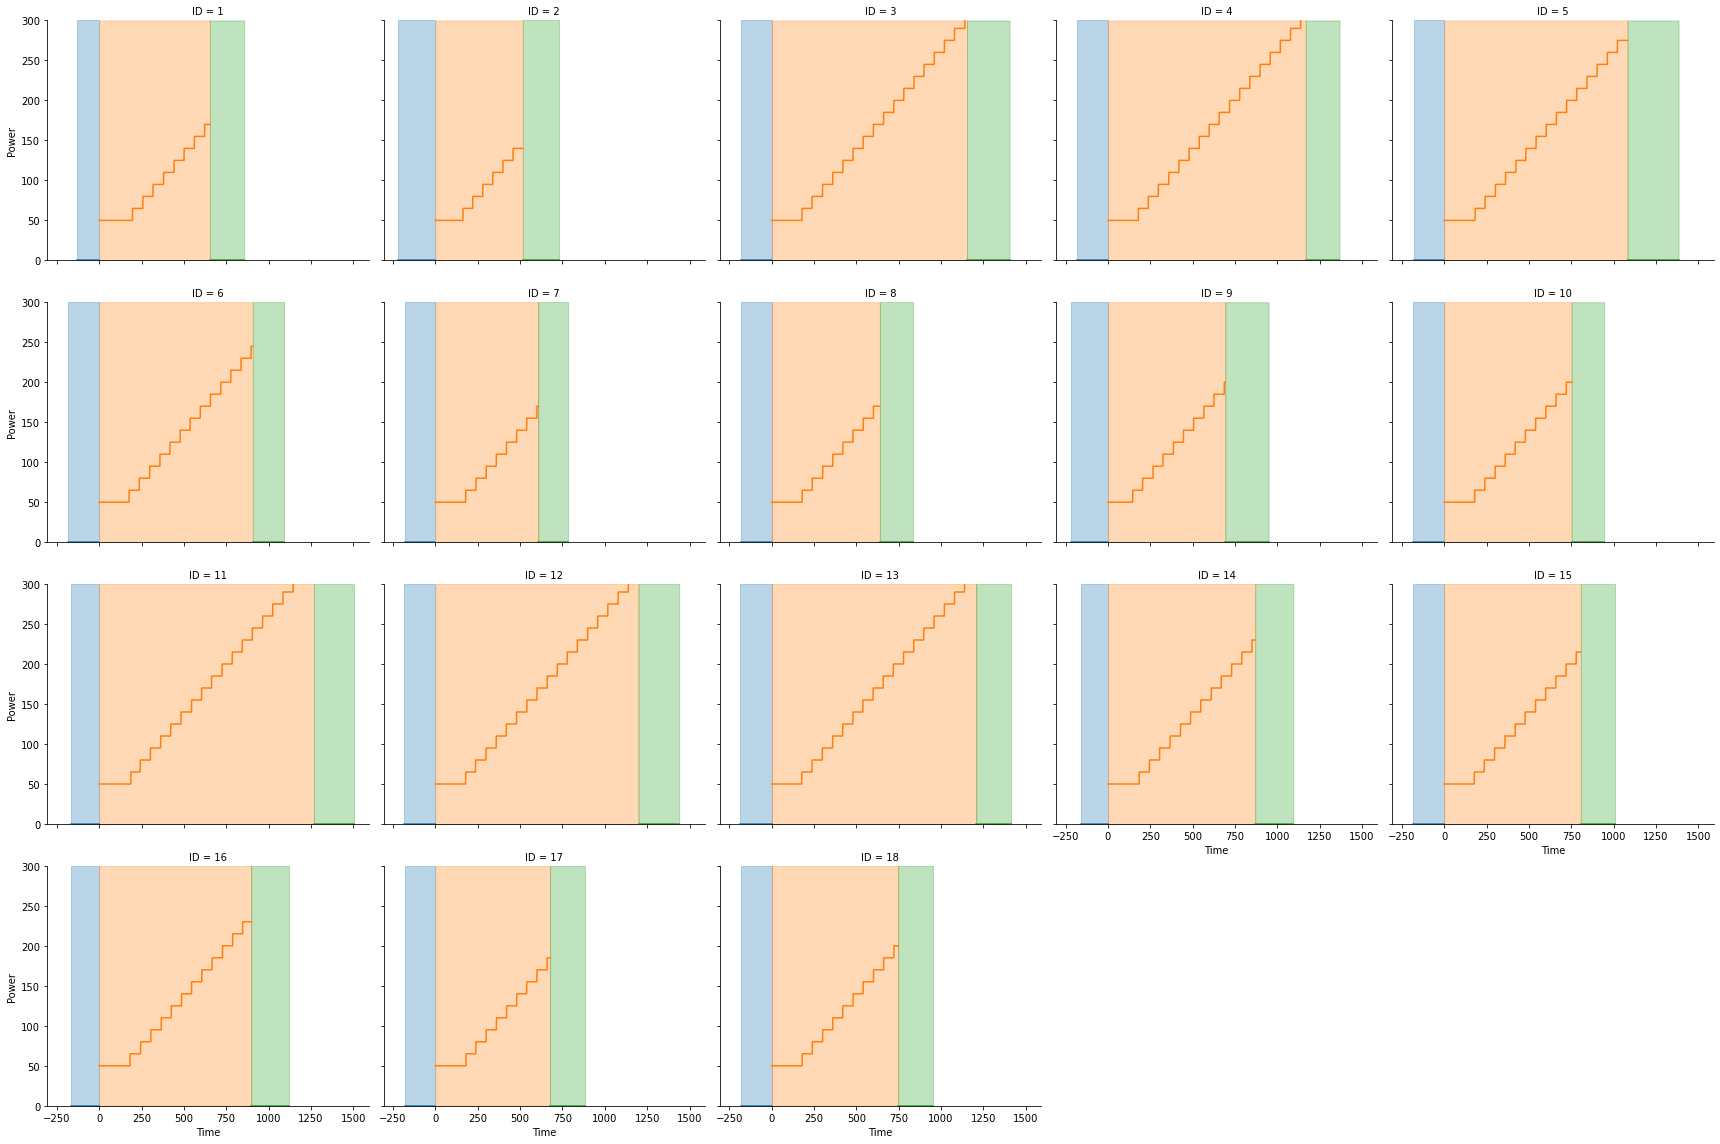

In [307]:
# Plot

g = sns.FacetGrid(data=ecg_data, col='ID', col_wrap=5, height=4, aspect=1.2,hue="test")
g = g.map(plt.plot, 'time', 'power')
g = g.map(plt.fill_between, 'time', y1=0, y2=300, alpha=0.3)
g = g.set_ylabels('Power')
g = g.set_xlabels('Time')
#g = g.add_legend()
plt.ylim(0, 300)
plt.show()

# 2.  Data Cleaning - Adding Columns (HR)

In [351]:
ecg_data['HR'] = 60000/ecg_data['RR']
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx,test,HR
0,1,-130.840,672.0,0.302008,0,1,1,11,rest,89.285714
1,1,-130.168,672.0,0.302008,0,1,1,11,rest,89.285714
2,1,-129.536,632.0,0.301336,0,1,1,11,rest,94.936709
3,1,-128.824,712.0,0.301336,0,1,1,11,rest,84.269663
4,1,-127.948,876.0,0.301336,0,1,1,11,rest,68.493151
...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery,111.940299
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery,113.636364
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery,113.636364
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery,111.111111


# Time_Rest column

In [354]:
def calculate_time_rest(group):
    recovery_times = ecg_data[ecg_data['test'] == 'recovery'].groupby('ID')['time'].first()
    id = group['ID'].iloc[0]
    first_recovery_time = recovery_times.loc[id]
    time_rest = group['time'] - first_recovery_time
    return time_rest

ecg_data['time_rest'] = ecg_data.groupby('ID').apply(calculate_time_rest).reset_index(drop=True)


In [355]:
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx,test,HR,time_rest
0,1,-130.840,672.0,0.302008,0,1,1,11,rest,89.285714,-785.020
1,1,-130.168,672.0,0.302008,0,1,1,11,rest,89.285714,-784.348
2,1,-129.536,632.0,0.301336,0,1,1,11,rest,94.936709,-783.716
3,1,-128.824,712.0,0.301336,0,1,1,11,rest,84.269663,-783.004
4,1,-127.948,876.0,0.301336,0,1,1,11,rest,68.493151,-782.128
...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery,111.940299,199.284
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery,113.636364,199.812
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery,113.636364,200.340
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery,111.111111,200.880


# HR_Mean and Vo2 Mean

In [356]:
ecg_data['HR_mean'] = ecg_data.groupby('ID')['HR'].rolling(window=100, min_periods=1).mean().reset_index(drop=True)
ecg_data['VO2_mean'] = ecg_data.groupby('ID')['VO2'].rolling(window=100, min_periods=1).mean().reset_index(drop=True)

In [357]:
ecg_data

,ID,time,RR,VO2,power,remain,power_idx,last_power_idx,test,HR,time_rest,HR_mean,VO2_mean
0,1,-130.840,672.0,0.302008,0,1,1,11,rest,89.285714,-785.020,89.285714,0.302008
1,1,-130.168,672.0,0.302008,0,1,1,11,rest,89.285714,-784.348,89.285714,0.302008
2,1,-129.536,632.0,0.301336,0,1,1,11,rest,94.936709,-783.716,91.169379,0.301784
3,1,-128.824,712.0,0.301336,0,1,1,11,rest,84.269663,-783.004,89.444450,0.301672
4,1,-127.948,876.0,0.301336,0,1,1,11,rest,68.493151,-782.128,85.254190,0.301604
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,1,13,13,recovery,111.940299,199.284,115.033084,0.461490
52051,18,947.816,528.0,0.507071,0,1,13,13,recovery,113.636364,199.812,114.978972,0.460423
52052,18,948.344,528.0,0.507071,0,1,13,13,recovery,113.636364,200.340,114.934233,0.459355
52053,18,948.884,540.0,0.507071,0,1,13,13,recovery,111.111111,200.880,114.854868,0.458288


In [358]:
test_max = ecg_data.groupby('ID').agg(
    HRmax=('HR_mean', 'max'),
    VO2max_abs=('VO2_mean', 'max'),
    powermax=('power', 'max')
)
test_max.reset_index(inplace=True)

In [363]:
test_max

,ID,HRmax,VO2max_abs,powermax
0,1,193.362384,1.556423,170
1,2,182.615885,1.795964,140
2,3,177.223686,3.240769,305
3,4,194.857957,2.797500,305
4,5,186.766835,3.131456,275
5,6,182.150183,2.892842,245
6,7,186.042266,1.322388,170
7,8,182.794291,1.839425,170
8,9,188.498008,1.552537,200
9,10,190.097371,2.032672,200


# HRR120 and HRR60

In [366]:
recovery_data = ecg_data[ecg_data['test'] == "recovery"]
HRR = recovery_data.groupby('ID').apply(lambda group: pd.Series({
    'HRR120': group['HR_mean'].iloc[0] - group[group['time_rest'] > 120]['HR_mean'].iloc[0],
    'HRR60': group['HR_mean'].iloc[0] - group[group['time_rest'] > 60]['HR_mean'].iloc[0]
})).reset_index()

In [367]:
HRR

,ID,HRR120,HRR60
0,1,43.523723,15.369819
1,2,56.615911,29.817986
2,3,44.779881,17.189525
3,4,40.056916,16.113339
4,5,44.284435,23.198961
5,6,52.410268,26.028475
6,7,60.814530,31.121756
7,8,54.002904,24.672129
8,9,40.372876,19.721101
9,10,30.664786,16.246111


In [368]:
Cleaned_sinfo = pd.merge(pd.merge(sinfo, test_max, on='ID'), HRR, on='ID')

In [370]:
Cleaned_sinfo['VO2max']=Cleaned_sinfo['VO2max_abs']/Cleaned_sinfo['Weight']
Cleaned_sinfo

,ID,age,Weight,Height,P_vt1,P_vt2,sport,HRmax,VO2max_abs,powermax,HRR120,HRR60,VO2max
0,1,15,53.7,161,50,140,fencing,193.362384,1.556423,170,43.523723,15.369819,0.028984
1,2,15,56.2,162,80,127,fencing,182.615885,1.795964,140,56.615911,29.817986,0.031957
2,3,16,89.9,191,155,300,fencing,177.223686,3.240769,305,44.779881,17.189525,0.036049
3,4,16,76.5,180,215,275,fencing,194.857957,2.797500,305,40.056916,16.113339,0.036569
4,5,17,76.4,186,110,172,fencing,186.766835,3.131456,275,44.284435,23.198961,0.040988
5,6,17,65.6,169,131,186,fencing,182.150183,2.892842,245,52.410268,26.028475,0.044098
6,7,15,49.8,165,65,108,fencing,186.042266,1.322388,170,60.814530,31.121756,0.026554
7,8,15,51.2,165,80,133,fencing,182.794291,1.839425,170,54.002904,24.672129,0.035926
8,9,14,57.1,176,50,125,fencing,188.498008,1.552537,200,40.372876,19.721101,0.027190
9,10,14,58.8,177,101,162,fencing,190.097371,2.032672,200,30.664786,16.246111,0.034569


# HR Rest

In [309]:
#To calculate HR rest and HR max, we need to group the data by ID and test sequence, and use the following formulas:

# calculate HR rest
hr_rest['HRrest']= ecg_data.groupby(['ID'])['HR'].mean()

hr_rest

ID
1                                                155.110805
2                                                139.277158
3                                                136.647228
4                                                149.006665
5                                                145.540187
6                                                136.729146
7                                                144.863255
8                                                 137.69714
9                                                153.356769
10                                               150.288667
11                                                139.52512
12                                               141.916278
13                                               143.114138
14                                                143.16124
15                                               144.940373
16                                                142.72215
17                                   

# HR Max and HRR 

In [310]:
# calculate HR max and HRR
ecg_data['power_idx'] = (ecg_data['power'] != ecg_data['power'].shift()).cumsum()
max_data = ecg_data.groupby(['ID', 'power_idx']).agg(
    HRmax=('HR', 'max'),
    VO2max_abs=('VO2', 'max'),
    powermax=('power', 'max')
).groupby(['ID']).agg(
    HRmax=('HRmax', 'max'),
    VO2max_abs=('VO2max_abs', 'max'),
    powermax=('powermax', 'max')
)


max_data

,HRmax,VO2max_abs,powermax
ID,,,
1,197.368421,1.789775,170
2,197.368421,1.959791,140
3,182.926829,3.455253,305
4,223.880597,3.437170,305
5,189.873418,3.386349,275
6,202.702703,3.415759,245
7,238.095238,1.658511,170
8,200.000000,1.994151,170
9,200.000000,1.742767,200


# Prediction of HR max based on age

In [311]:
sinfo['MaxHR_Pred']=220-sinfo['age']

# Merged Sinfo and max_data

In [312]:
df = pd.merge(sinfo, max_data, on='ID')

df

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200


In [313]:
df1=pd.merge(df,hr_rest,on='ID')

df1 = df1.rename(columns={'HR': 'HRrest'})
df1


,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667


# Merged Ecg_data and df1 dataframe for Percentage of HR max calculation

In [314]:
merged_df=pd.merge(ecg_data,df1,on='ID')
merged_df

,ID,time,RR,VO2,power,power_idx,last_power_idx,test,HR,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest
0,1,-130.840,672.0,0.302008,0,1,11,rest,89.285714,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805
1,1,-130.168,672.0,0.302008,0,1,11,rest,89.285714,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805
2,1,-129.536,632.0,0.301336,0,1,11,rest,94.936709,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805
3,1,-128.824,712.0,0.301336,0,1,11,rest,84.269663,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805
4,1,-127.948,876.0,0.301336,0,1,11,rest,68.493151,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,257,13,recovery,111.940299,12,39.7,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378
52051,18,947.816,528.0,0.507071,0,257,13,recovery,113.636364,12,39.7,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378
52052,18,948.344,528.0,0.507071,0,257,13,recovery,113.636364,12,39.7,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378
52053,18,948.884,540.0,0.507071,0,257,13,recovery,111.111111,12,39.7,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378


In [315]:
merged_df['HRmax%']=(merged_df['HR']/merged_df['HRmax'])*100
merged_df

,ID,time,RR,VO2,power,power_idx,last_power_idx,test,HR,age,...,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRmax%
0,1,-130.840,672.0,0.302008,0,1,11,rest,89.285714,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,45.238095
1,1,-130.168,672.0,0.302008,0,1,11,rest,89.285714,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,45.238095
2,1,-129.536,632.0,0.301336,0,1,11,rest,94.936709,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,48.101266
3,1,-128.824,712.0,0.301336,0,1,11,rest,84.269663,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,42.696629
4,1,-127.948,876.0,0.301336,0,1,11,rest,68.493151,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,34.703196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52050,18,947.288,536.0,0.507071,0,257,13,recovery,111.940299,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,56.716418
52051,18,947.816,528.0,0.507071,0,257,13,recovery,113.636364,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,57.575758
52052,18,948.344,528.0,0.507071,0,257,13,recovery,113.636364,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,57.575758
52053,18,948.884,540.0,0.507071,0,257,13,recovery,111.111111,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,56.296296


# heart rate reserve (HRR) = HRR = HRmax – HRrest

#merged_df= similar to tm and df1 = similar to dinfo

In [316]:
df1['HRR']=df1['HRmax']-df1['HRrest']
df1

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRR
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,42.257616
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,58.091263
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,46.279601
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,74.873932
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,44.33323
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,65.973557
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,93.231983
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,62.30286
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,46.643231
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,42.019025


#  ATHR 

In [317]:
df1['ATHR']=df1['HRmax']*0.85
df1

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRR,ATHR
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,42.257616,167.763158
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,58.091263,167.763158
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,46.279601,155.487805
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,74.873932,190.298507
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,44.33323,161.392405
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,65.973557,172.297297
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,93.231983,202.380952
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,62.30286,170.000000
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,46.643231,170.000000
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,42.019025,163.461538


# Excerise intensity = ATHR-HRrest/HRR 

In [318]:
df1['Intensity']=df1['ATHR']-df1['HRrest']/df1['HRR']
df1

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRR,ATHR,Intensity
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,42.257616,167.763158,164.092558
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,58.091263,167.763158,165.3656
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,46.279601,155.487805,152.53516
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,74.873932,190.298507,188.308407
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,44.33323,161.392405,158.109536
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,65.973557,172.297297,170.224813
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,93.231983,202.380952,200.827159
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,62.30286,170.000000,167.789874
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,46.643231,170.000000,166.712132
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,42.019025,163.461538,159.884857


# VO2 Max calculation 1 : (VO2max*1000/W)

In [319]:
df1['Vo2inmL/Kg/min']=df1['VO2max_abs']*1000/df1['Weight']
df1


,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRR,ATHR,Intensity,Vo2inmL/Kg/min
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,42.257616,167.763158,164.092558,33.329152
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,58.091263,167.763158,165.3656,34.871720
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,46.279601,155.487805,152.53516,38.434406
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,74.873932,190.298507,188.308407,44.930322
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,44.33323,161.392405,158.109536,44.323937
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,65.973557,172.297297,170.224813,52.069497
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,93.231983,202.380952,200.827159,33.303437
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,62.30286,170.000000,167.789874,38.948254
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,46.643231,170.000000,166.712132,30.521318
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,42.019025,163.461538,159.884857,40.015518


# VO2 Max calculation 2 : (10.8*power/weight)+7)

In [320]:
df1['Vo2inmL/Kg/min/2']=(10.8*df1['powermax']/df1['Weight'])+7      
df1


,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRR,ATHR,Intensity,Vo2inmL/Kg/min,Vo2inmL/Kg/min/2
0,1,15,53.7,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,42.257616,167.763158,164.092558,33.329152,41.189944
1,2,15,56.2,162,80,127,fencing,205,197.368421,1.959791,140,139.277158,58.091263,167.763158,165.3656,34.871720,33.903915
2,3,16,89.9,191,155,300,fencing,204,182.926829,3.455253,305,136.647228,46.279601,155.487805,152.53516,38.434406,43.640712
3,4,16,76.5,180,215,275,fencing,204,223.880597,3.437170,305,149.006665,74.873932,190.298507,188.308407,44.930322,50.058824
4,5,17,76.4,186,110,172,fencing,203,189.873418,3.386349,275,145.540187,44.33323,161.392405,158.109536,44.323937,45.874346
5,6,17,65.6,169,131,186,fencing,203,202.702703,3.415759,245,136.729146,65.973557,172.297297,170.224813,52.069497,47.335366
6,7,15,49.8,165,65,108,fencing,205,238.095238,1.658511,170,144.863255,93.231983,202.380952,200.827159,33.303437,43.867470
7,8,15,51.2,165,80,133,fencing,205,200.000000,1.994151,170,137.69714,62.30286,170.000000,167.789874,38.948254,42.859375
8,9,14,57.1,176,50,125,fencing,206,200.000000,1.742767,200,153.356769,46.643231,170.000000,166.712132,30.521318,44.828371
9,10,14,58.8,177,101,162,fencing,206,192.307692,2.352912,200,150.288667,42.019025,163.461538,159.884857,40.015518,43.734694


# Data cleaning where power !=0

In [321]:
merged_df=merged_df[merged_df.power != 0]
merged_df

,ID,time,RR,VO2,power,power_idx,last_power_idx,test,HR,age,...,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRmax%
173,1,0.000,800.0,0.266493,50,2,11,0,75.000000,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,38.000000
174,1,0.912,912.0,0.266493,50,2,11,0,65.789474,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,33.333333
175,1,1.620,708.0,0.266493,50,2,11,0,84.745763,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,42.937853
176,1,2.276,656.0,0.246344,50,2,11,0,91.463415,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,46.341463
177,1,2.952,676.0,0.246344,50,2,11,0,88.757396,15,...,161,50,140,fencing,205,197.368421,1.789775,170,155.110805,44.970414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51592,18,746.412,316.0,1.795226,200,256,13,0,189.873418,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,96.202532
51593,18,746.732,320.0,1.597605,200,256,13,0,187.500000,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,95.000000
51594,18,747.048,316.0,1.597605,200,256,13,0,189.873418,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,96.202532
51595,18,747.368,320.0,1.597605,200,256,13,0,187.500000,12,...,158,65,168,triathlon,208,197.368421,2.204238,200,146.146378,95.000000


In [323]:
merged_df.columns

Index(['ID', 'time', 'RR', 'VO2', 'power', 'power_idx', 'last_power_idx',
       'test', 'HR', 'age', 'Weight', 'Height', 'P_vt1', 'P_vt2', 'sport',
       'MaxHR_Pred', 'HRmax', 'VO2max_abs', 'powermax', 'HRrest', 'HRmax%'],
      dtype='object')

# Removed the repeated columns from another df

In [233]:
'''merged_df=merged_df.drop(['power_idx','last_power_idx_x','test','last_power_idx_y','last_power_idx'],axis=1)
merged_df=merged_df.drop(['age','Weight','Height','P_vt1','P_vt2','sport'],axis=1)
merged_df=merged_df.drop(['HRmax','MaxHR_Pred','VO2max_abs','powermax','HRrest'],axis=1)'''

In [326]:
merged_df=merged_df.drop(['power_idx', 'last_power_idx',
       'test', 'age', 'Weight', 'Height', 'P_vt1', 'P_vt2', 'sport',
       'MaxHR_Pred', 'HRmax', 'VO2max_abs', 'powermax', 'HRrest'],axis=1)


KeyError: "['power_idx', 'last_power_idx', 'test', 'age', 'Weight', 'Height', 'P_vt1', 'P_vt2', 'sport', 'MaxHR_Pred', 'HRmax', 'VO2max_abs', 'powermax', 'HRrest'] not found in axis"

In [327]:
merged_df

,ID,time,RR,VO2,power,HR,HRmax%
173,1,0.000,800.0,0.266493,50,75.000000,38.000000
174,1,0.912,912.0,0.266493,50,65.789474,33.333333
175,1,1.620,708.0,0.266493,50,84.745763,42.937853
176,1,2.276,656.0,0.246344,50,91.463415,46.341463
177,1,2.952,676.0,0.246344,50,88.757396,44.970414
...,...,...,...,...,...,...,...
51592,18,746.412,316.0,1.795226,200,189.873418,96.202532
51593,18,746.732,320.0,1.597605,200,187.500000,95.000000
51594,18,747.048,316.0,1.597605,200,189.873418,96.202532
51595,18,747.368,320.0,1.597605,200,187.500000,95.000000


In [235]:
#Round of decimal value 2

In [328]:
cols = ['time','VO2','HR','HRmax%']
merged_df[cols] = round(merged_df[cols],2)
merged_df

,ID,time,RR,VO2,power,HR,HRmax%
173,1,0.00,800.0,0.27,50,75.00,38.00
174,1,0.91,912.0,0.27,50,65.79,33.33
175,1,1.62,708.0,0.27,50,84.75,42.94
176,1,2.28,656.0,0.25,50,91.46,46.34
177,1,2.95,676.0,0.25,50,88.76,44.97
...,...,...,...,...,...,...,...
51592,18,746.41,316.0,1.80,200,189.87,96.20
51593,18,746.73,320.0,1.60,200,187.50,95.00
51594,18,747.05,316.0,1.60,200,189.87,96.20
51595,18,747.37,320.0,1.60,200,187.50,95.00


In [329]:
#Changing the dtype to float for round of
df1[['HRrest','HRR','Intensity']]=df1[['HRrest','HRR','Intensity']].astype(float)

cols = ['HRmax','VO2max_abs','HRrest','HRR','ATHR','Intensity']
df1[cols] = round(df1[cols],2)
df1

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRR,ATHR,Intensity,Vo2inmL/Kg/min,Vo2inmL/Kg/min/2
0,1,15,53.7,161,50,140,fencing,205,197.37,1.79,170,155.11,42.26,167.76,164.09,33.329152,41.189944
1,2,15,56.2,162,80,127,fencing,205,197.37,1.96,140,139.28,58.09,167.76,165.37,34.871720,33.903915
2,3,16,89.9,191,155,300,fencing,204,182.93,3.46,305,136.65,46.28,155.49,152.54,38.434406,43.640712
3,4,16,76.5,180,215,275,fencing,204,223.88,3.44,305,149.01,74.87,190.30,188.31,44.930322,50.058824
4,5,17,76.4,186,110,172,fencing,203,189.87,3.39,275,145.54,44.33,161.39,158.11,44.323937,45.874346
5,6,17,65.6,169,131,186,fencing,203,202.70,3.42,245,136.73,65.97,172.30,170.22,52.069497,47.335366
6,7,15,49.8,165,65,108,fencing,205,238.10,1.66,170,144.86,93.23,202.38,200.83,33.303437,43.867470
7,8,15,51.2,165,80,133,fencing,205,200.00,1.99,170,137.70,62.30,170.00,167.79,38.948254,42.859375
8,9,14,57.1,176,50,125,fencing,206,200.00,1.74,200,153.36,46.64,170.00,166.71,30.521318,44.828371
9,10,14,58.8,177,101,162,fencing,206,192.31,2.35,200,150.29,42.02,163.46,159.88,40.015518,43.734694


In [330]:
df1

,ID,age,Weight,Height,P_vt1,P_vt2,sport,MaxHR_Pred,HRmax,VO2max_abs,powermax,HRrest,HRR,ATHR,Intensity,Vo2inmL/Kg/min,Vo2inmL/Kg/min/2
0,1,15,53.7,161,50,140,fencing,205,197.37,1.79,170,155.11,42.26,167.76,164.09,33.329152,41.189944
1,2,15,56.2,162,80,127,fencing,205,197.37,1.96,140,139.28,58.09,167.76,165.37,34.871720,33.903915
2,3,16,89.9,191,155,300,fencing,204,182.93,3.46,305,136.65,46.28,155.49,152.54,38.434406,43.640712
3,4,16,76.5,180,215,275,fencing,204,223.88,3.44,305,149.01,74.87,190.30,188.31,44.930322,50.058824
4,5,17,76.4,186,110,172,fencing,203,189.87,3.39,275,145.54,44.33,161.39,158.11,44.323937,45.874346
5,6,17,65.6,169,131,186,fencing,203,202.70,3.42,245,136.73,65.97,172.30,170.22,52.069497,47.335366
6,7,15,49.8,165,65,108,fencing,205,238.10,1.66,170,144.86,93.23,202.38,200.83,33.303437,43.867470
7,8,15,51.2,165,80,133,fencing,205,200.00,1.99,170,137.70,62.30,170.00,167.79,38.948254,42.859375
8,9,14,57.1,176,50,125,fencing,206,200.00,1.74,200,153.36,46.64,170.00,166.71,30.521318,44.828371
9,10,14,58.8,177,101,162,fencing,206,192.31,2.35,200,150.29,42.02,163.46,159.88,40.015518,43.734694


In [331]:
merged_df

,ID,time,RR,VO2,power,HR,HRmax%
173,1,0.00,800.0,0.27,50,75.00,38.00
174,1,0.91,912.0,0.27,50,65.79,33.33
175,1,1.62,708.0,0.27,50,84.75,42.94
176,1,2.28,656.0,0.25,50,91.46,46.34
177,1,2.95,676.0,0.25,50,88.76,44.97
...,...,...,...,...,...,...,...
51592,18,746.41,316.0,1.80,200,189.87,96.20
51593,18,746.73,320.0,1.60,200,187.50,95.00
51594,18,747.05,316.0,1.60,200,189.87,96.20
51595,18,747.37,320.0,1.60,200,187.50,95.00


# Copy the df into Excel

In [332]:
df1.to_csv("InsightsCrew_Cardiorespiratoryfitness_sinfo_Cleanedreport.csv", index=False)

In [333]:
merged_df.to_csv("InsightsCrew_Cardiorespiratoryfitness_tm_Cleanedreport.csv", index=False)
